In [4]:
# Import necessary libraries
import pandas as pd
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

Loading The Data

In [5]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Importing the Data from MyDrive.
data = pd.read_csv("/content/drive/MyDrive/nlptask1/labeled_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Data Pre-Processing

In [7]:
# Data cleaning
def clean_text(text):
    text = re.sub(r"RT @[\w]*:", "", text)  # remove retweet text "RT @username:"
    text = re.sub(r"@\w*", "", text)  # remove mentioned usernames
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z']", " ", text)  # keeping only letters and apostrophes
    text = re.sub(r'\s+', ' ', text).strip()  # removing the extra spaces
    return text

In [8]:
# Applying cleaning to the tweet column
data['clean_tweet'] = data['tweet'].apply(clean_text)

Splitting the Dataset

In [9]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_tweet'], data['class'], test_size=0.2, random_state=42)

Building The Models

In [10]:
# Tokenization and padding for LSTM
max_len = 50  # Maximum length of sequence
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [11]:
# Tokenization for BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_bert = bert_tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors="tf")
X_test_bert = bert_tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors="tf")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Preparing the model inputs
X_train_input = {'input_ids': X_train_bert['input_ids'], 'attention_mask': X_train_bert['attention_mask']}
X_test_input = {'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']}

In [13]:
# Building the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = Input(shape=(max_len,), dtype='int32', name="input_ids")
attention_mask = Input(shape=(max_len,), dtype='int32', name="attention_mask")
bert_output = bert_model(input_ids, attention_mask=attention_mask)
out = Dense(1, activation='sigmoid')(bert_output[1])
bert_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)
bert_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
# Building the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
lstm_model = tf.keras.Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(64, dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training the models

In [15]:
# Training the BERT model
bert_model.fit(X_train_input, y_train, batch_size=32, epochs=1, validation_split=0.1)

558/558 [==============================] - 6772s 12s/step - loss: -17.3186 - accuracy: 0.7707 - val_loss: -36.8054 - val_accuracy: 0.7796


In [16]:
# Training the LSTM model
lstm_model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
558/558 [==============================] - 28s 45ms/step - loss: -2.4197 - accuracy: 0.7741 - val_loss: -4.3396 - val_accuracy: 0.7796
Epoch 2/10
558/558 [==============================] - 20s 37ms/step - loss: -5.5841 - accuracy: 0.7741 - val_loss: -7.6377 - val_accuracy: 0.7796
Epoch 3/10
558/558 [==============================] - 21s 38ms/step - loss: -8.6350 - accuracy: 0.7741 - val_loss: -10.8953 - val_accuracy: 0.7796
Epoch 4/10
558/558 [==============================] - 20s 36ms/step - loss: -11.6761 - accuracy: 0.7741 - val_loss: -14.1417 - val_accuracy: 0.7796
Epoch 5/10
558/558 [==============================] - 21s 38ms/step - loss: -14.6928 - accuracy: 0.7741 - val_loss: -17.3641 - val_accuracy: 0.7796
Epoch 6/10
558/558 [==============================] - 20s 36ms/step - loss: -17.6888 - accuracy: 0.7741 - val_loss: -20.5781 - val_accuracy: 0.7796
Epoch 7/10
558/558 [==============================] - 21s 38ms/step - loss: -20.6803 - accuracy: 0.7741 - val_loss: -

155/155 [==============================] - 1s 8ms/step


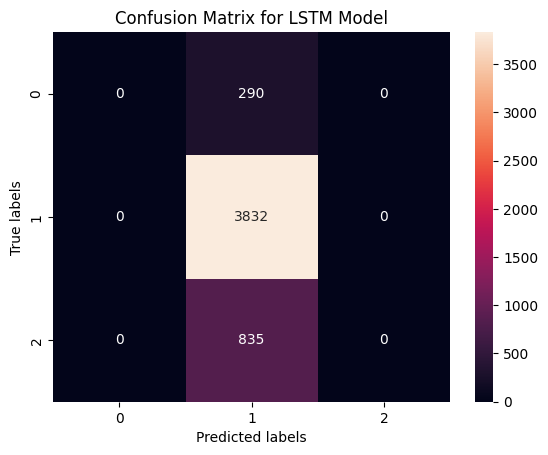

In [17]:
# Evaluating and create confusion matrices
# For the LSTM model
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype("int32")
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm_classes)
sns.heatmap(conf_matrix_lstm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

155/155 [==============================] - 555s 4s/step


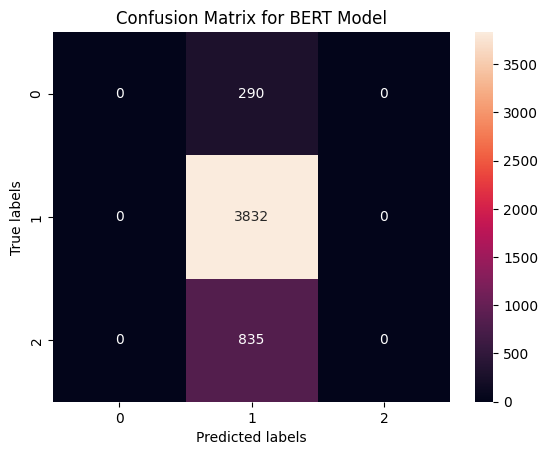

In [18]:
# For the BERT model
y_pred_bert = bert_model.predict(X_test_input)
y_pred_bert_classes = (y_pred_bert > 0.5).astype("int32")
conf_matrix_bert = confusion_matrix(y_test, y_pred_bert_classes)
sns.heatmap(conf_matrix_bert, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for BERT Model')
plt.show()

Classification Report

In [21]:
from sklearn.metrics import classification_report

# For the LSTM model
# Making predictions with the LSTM model
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype("int32")

# Generating and print the classification report
print("Classification Report for LSTM Model:")
print(classification_report(y_test, y_pred_lstm_classes))



155/155 [==============================] - 1s 6ms/step
Classification Report for LSTM Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.77      1.00      0.87      3832
           2       0.00      0.00      0.00       835

    accuracy                           0.77      4957
   macro avg       0.26      0.33      0.29      4957
weighted avg       0.60      0.77      0.67      4957



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# For the BERT model
# Making predictions with the BERT model
y_pred_bert = bert_model.predict(X_test_input)
y_pred_bert_classes = (y_pred_bert > 0.5).astype("int32")

# Generating and print the classification report
print("Classification Report for BERT Model:")
print(classification_report(y_test, y_pred_bert_classes))


155/155 [==============================] - 544s 4s/step
Classification Report for BERT Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.77      1.00      0.87      3832
           2       0.00      0.00      0.00       835

    accuracy                           0.77      4957
   macro avg       0.26      0.33      0.29      4957
weighted avg       0.60      0.77      0.67      4957



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
